In [1]:
import torch
import shap
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as torch_optim
from tqdm.notebook import tqdm_notebook
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from torch.utils.data import TensorDataset, DataLoader

from warnings import filterwarnings

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(str(device))

%matplotlib inline
filterwarnings('ignore')

cuda:0


In [3]:
# Считываем данные
tr_mcc_codes = pd.read_csv('tr_mcc_codes.csv', sep=';', index_col='mcc_code')
tr_types = pd.read_csv('tr_types.csv', sep=';', index_col='tr_type')

transactions = pd.read_csv('transactions.csv', index_col='customer_id')
gender_train = pd.read_csv('gender_train.csv', index_col='customer_id')
gender_test = pd.read_csv('gender_test_kaggle_sample_submission.csv', index_col='customer_id')

transactions_train = transactions.join(gender_train, how='inner')
transactions_train = transactions_train.join(tr_mcc_codes, how='inner', on='mcc_code')
transactions_train = transactions_train.join(tr_types, how='inner', on='tr_type')

transactions_test = transactions.join(gender_test, how='inner')
transactions_test = transactions_test.join(tr_mcc_codes, how='inner', on='mcc_code')
transactions_test = transactions_test.join(tr_types, how='inner', on='tr_type')

transactions_train['log_amount'] = np.sign(transactions_train['amount'])*np.log10(np.abs(transactions_train['amount']))  
transactions_test['log_amount'] = np.sign(transactions_test['amount'])*np.log10(np.abs(transactions_test['amount'])) 


del transactions

In [4]:
for df in [transactions_train, transactions_test]:
    df['day'] = df['tr_datetime'].str.split().apply(lambda x: int(x[0]) % 7)
    df['hour'] = df['tr_datetime'].apply(lambda x: re.search(' \d*', x).group(0)).astype(int)
    df['night'] = ~df['hour'].between(6, 22).astype(int)

def create_features(x):
    features = []
    features.append(pd.Series(x['mcc_description'].value_counts(normalize=True).add_prefix('mcc_')))
    features.append(pd.Series(x['tr_type'].value_counts(normalize=True).add_prefix('trt_')))
    features.append(pd.Series(x['day'].value_counts(normalize=True).add_prefix('day_')))
    features.append(pd.Series(x['hour'].value_counts(normalize=True).add_prefix('hour_')))
    features.append(pd.Series(x['night'].value_counts(normalize=True).add_prefix('night_')))
    features.append(pd.Series(x[x['log_amount']>0]['log_amount'].agg(['min', 'max', 'mean', 'median', 'std', 'count'])\
                                                        .add_prefix('positive_transactions_')))
    features.append(pd.Series(x[x['log_amount']<0]['log_amount'].agg(['min', 'max', 'mean', 'median', 'std', 'count'])\
                                                        .add_prefix('negative_transactions_')))
    result = x.groupby('mcc_code')['log_amount'].mean()
    result.index = result.index.map(lambda e: 'mcc_code_mean' + str(e))
    features.append(result)
    return pd.concat(features)

In [5]:
tqdm_notebook.pandas(desc="Progress:")
data_train = transactions_train.groupby(transactions_train.index)\
                               .progress_apply(create_features).unstack(-1)

Progress::   0%|          | 0/8400 [00:00<?, ?it/s]

In [8]:
train = data_train.fillna(0)
target = train.join(gender_train, how='inner')['gender']

In [9]:
X_train, X_test, y_train, y_test = train_test_split(train, target, test_size=0.2, random_state=35)

train_dataset = TensorDataset(torch.tensor(X_train.values, dtype=torch.float32), torch.tensor(y_train.values, dtype=torch.float32))
train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)

test_dataset = TensorDataset(torch.tensor(X_test.values, dtype=torch.float32), torch.tensor(y_test.values, dtype=torch.float32))
test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=True)

In [10]:
class NN(nn.Module):
    def __init__(self, 
                 input_size, 
                 num_layers=1, 
                 layer_size=100,
                 activation=F.relu):
        super().__init__()
        
        self.input_layer = nn.Linear(input_size, layer_size)
        self.layers = []
        for _ in range(num_layers - 1):
            self.layers.append(nn.Linear(layer_size, layer_size))

        self.layers = nn.ModuleList(self.layers)
        self.output_layer = nn.Linear(layer_size, 1)
        
        self.activation = activation

    def forward(self, input):
        output = self.activation(self.input_layer(input))
        for layer in self.layers:
            output = self.activation(layer(output))
        output = self.output_layer(output)
        
        return output

In [11]:
def train_model(model, 
                train_dataloader, 
                val_dataloader,
                device, 
                num_epochs = 10,
                lr = 10e-5,
                show=True):
    parameters = filter(lambda p: p.requires_grad, model.parameters())
    optimizer = torch_optim.Adam(parameters, lr=lr)

    loss_function = nn.BCEWithLogitsLoss()

    train_losses = []
    train_roc_aucs = []
    val_losses = []
    val_roc_aucs = []
    for e in range(num_epochs):
        model.train()

        epoch_train_loss = 0
        epoch_train_roc_auc = 0

        for X_batch, y_batch in train_dataloader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            
            optimizer.zero_grad()
            
            y_pred = model(X_batch)
            
            loss = loss_function(y_pred, y_batch.unsqueeze(1))
            roc_auc = roc_auc_score(y_batch.unsqueeze(1).ravel().cpu(), 
                                    torch.sigmoid(y_pred).ravel().cpu().detach().numpy())
            
            loss.backward()
            optimizer.step()
            
            epoch_train_loss += loss.item()
            epoch_train_roc_auc += roc_auc.item()

        model.eval()
            
        epoch_val_loss = 0
        epoch_val_roc_auc = 0

        for X_batch, y_batch in val_dataloader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)

            y_pred = model(X_batch)
            
            loss = loss_function(y_pred, y_batch.unsqueeze(1))
            roc_auc = roc_auc_score(y_batch.unsqueeze(1).ravel().cpu(), 
                                    torch.sigmoid(y_pred).ravel().cpu().detach().numpy())

            epoch_val_loss += loss.item()
            epoch_val_roc_auc += roc_auc.item()
        
        train_losses.append(epoch_train_loss / len(train_dataloader))
        train_roc_aucs.append(epoch_train_roc_auc / len(train_dataloader))
        val_losses.append(epoch_val_loss / len(val_dataloader))
        val_roc_aucs.append(epoch_val_roc_auc / len(val_dataloader))

    if show:
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 3))
        x = range(len(train_losses))
        ax1.plot(x, train_losses, label='Train')
        ax1.plot(x, val_losses, label='Test')
        ax1.set_xlabel('Epoch')
        ax1.set_ylabel('Loss')
        ax1.legend()
        ax2.plot(x, train_roc_aucs, label='Train')
        ax2.plot(x, val_roc_aucs, label='Test')
        ax2.set_xlabel('Epoch')
        ax2.set_ylabel('ROC AUC')
        ax2.legend()
        plt.show()

    return np.array(val_roc_aucs).max()

In [12]:
def format_name(function):
    return str(function).split(' ')[1]

In [13]:
def testNN(layer_size, num_layers=1, activation=F.relu, num_epochs=10, show=True):
   
    model = NN(X_train.shape[1], num_layers=num_layers, layer_size=layer_size, activation=activation)
    model.to(device)
    best_metric = train_model(model, train_dataloader, test_dataloader, device, num_epochs=num_epochs, show=show)
    if show:
        print(f"Neurons: {layer_size};\n Layers: {num_layers}; \n Function: {format_name(activation)}; \n Best result: {best_metric}")
    return best_metric

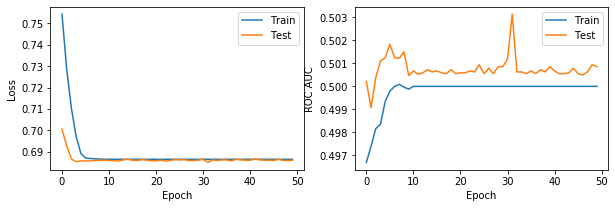

Neurons: 1;
 Layers: 1; 
 Function: relu; 
 Best result: 0.5031446540880503

---



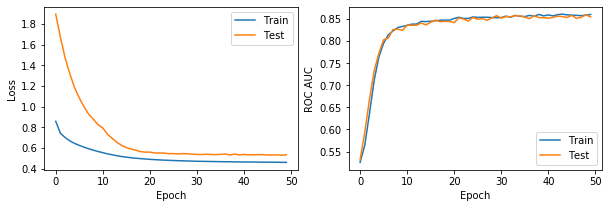

Neurons: 5;
 Layers: 1; 
 Function: relu; 
 Best result: 0.8586585179735063

---



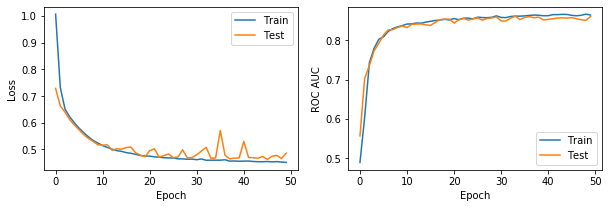

Neurons: 10;
 Layers: 1; 
 Function: relu; 
 Best result: 0.8614597193993804

---



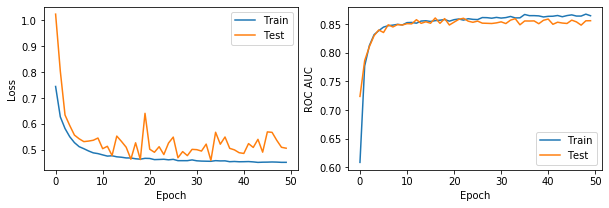

Neurons: 20;
 Layers: 1; 
 Function: relu; 
 Best result: 0.861035100101884

---



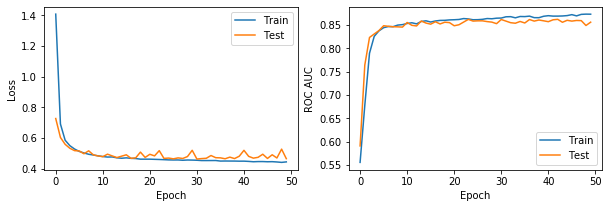

Neurons: 40;
 Layers: 1; 
 Function: relu; 
 Best result: 0.8619499323263786

---



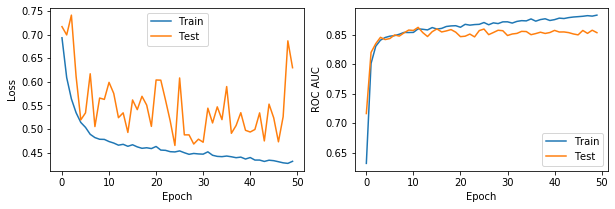

Neurons: 80;
 Layers: 1; 
 Function: relu; 
 Best result: 0.862265817423922

---



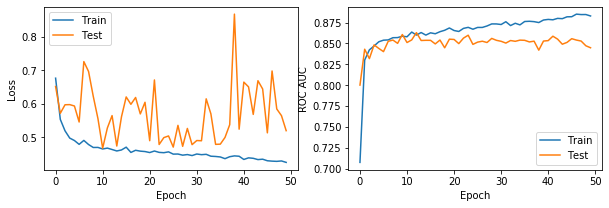

Neurons: 160;
 Layers: 1; 
 Function: relu; 
 Best result: 0.8629888118636366

---



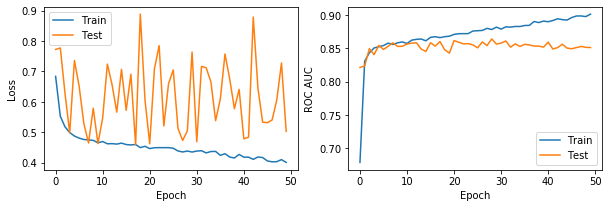

Neurons: 320;
 Layers: 1; 
 Function: relu; 
 Best result: 0.8640593242324082

---



In [134]:
#Меняем количество нейронов

res = pd.DataFrame(columns=['neurons', 'layers', 'function', 'epochs', 'roc_auc_score', 'index'])
epochs = 50
f = F.relu
layers = 1
neurons = [1, 5, 10, 20, 40, 80, 160, 320]
for n in neurons:
  roc_auc = testNN(n, activation=f, num_epochs=epochs, num_layers=layers);
  res.loc[len(res)] = [n, layers, format_name(f), epochs, roc_auc, 1]
  print('\n---\n')

In [135]:
res.sort_values(by=['roc_auc_score'], ascending=False).loc[:, res.columns != 'index'].loc[res['index']== 1]

,neurons,layers,function,epochs,roc_auc_score
7,320,1,relu,50,0.864059
6,160,1,relu,50,0.862989
5,80,1,relu,50,0.862266
4,40,1,relu,50,0.861950
2,10,1,relu,50,0.861460
3,20,1,relu,50,0.861035
1,5,1,relu,50,0.858659
0,1,1,relu,50,0.503145


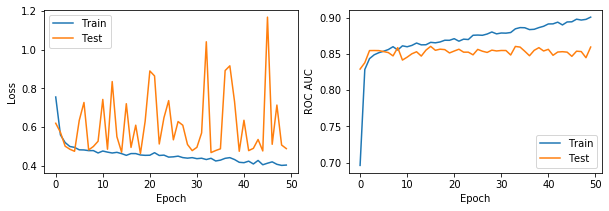

Neurons: 320;
 Layers: 1; 
 Function: relu; 
 Best result: 0.8603825635305188

---



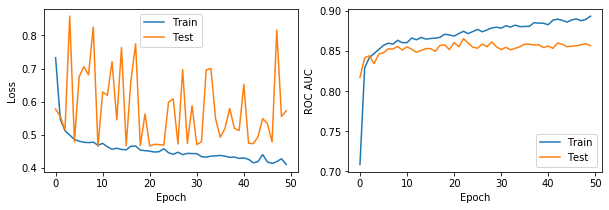

Neurons: 320;
 Layers: 1; 
 Function: elu; 
 Best result: 0.8652966129784192

---



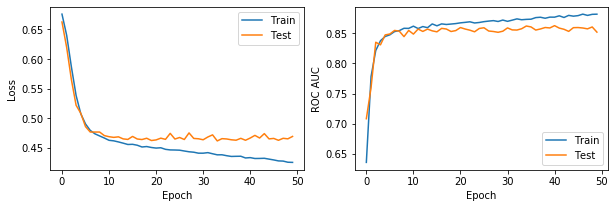

Neurons: 320;
 Layers: 1; 
 Function: method; 
 Best result: 0.8628986103846743

---



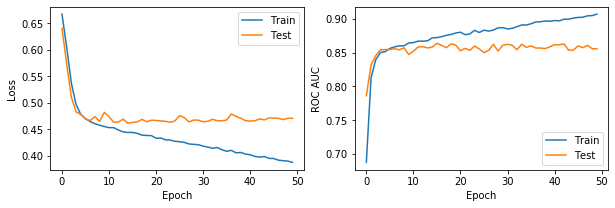

Neurons: 320;
 Layers: 1; 
 Function: softsign; 
 Best result: 0.8636276291765155

---



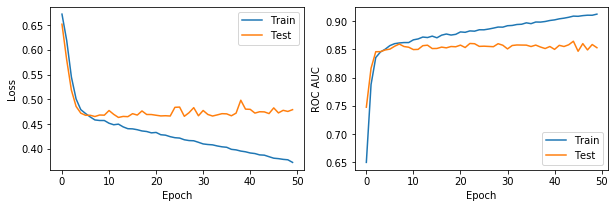

Neurons: 320;
 Layers: 1; 
 Function: method; 
 Best result: 0.8645827783010186

---



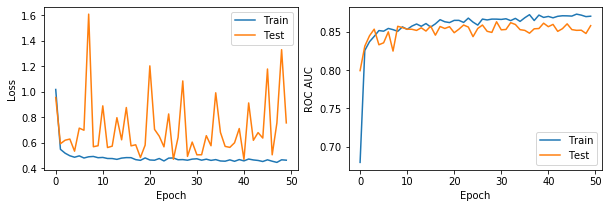

Neurons: 320;
 Layers: 1; 
 Function: hardshrink; 
 Best result: 0.863159609200292

---



In [137]:
#Меняем функции активации

epochs = 50
functions = [F.relu, F.elu, torch.sigmoid, F.softsign, torch.tanh, F.hardshrink]
layers = 1
neurons = 320
for fun in functions:
  roc_auc = testNN(neurons, activation=fun, num_epochs=epochs, num_layers=layers);
  res.loc[len(res)] = [n, layers, format_name(fun), epochs, roc_auc, 2]
  print('\n---\n')

In [138]:
res.sort_values(by=['roc_auc_score'], ascending=False).loc[:, res.columns != 'index'].loc[res['index']== 2]

,neurons,layers,function,epochs,roc_auc_score
9,320,1,elu,50,0.865297
12,320,1,method,50,0.864583
11,320,1,softsign,50,0.863628
13,320,1,hardshrink,50,0.863160
10,320,1,method,50,0.862899
8,320,1,relu,50,0.860383


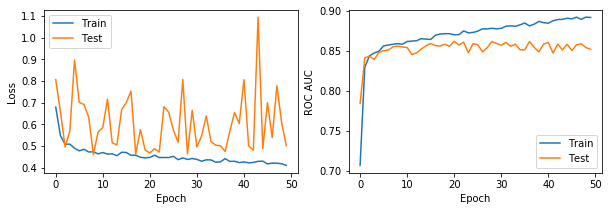

Neurons: 320;
 Layers: 1; 
 Function: elu; 
 Best result: 0.861870019509248

---



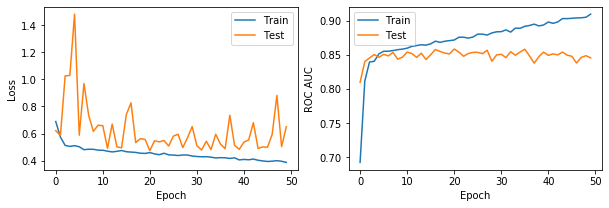

Neurons: 320;
 Layers: 2; 
 Function: elu; 
 Best result: 0.8584322930623232

---



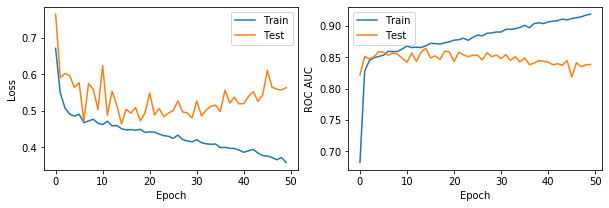

Neurons: 320;
 Layers: 3; 
 Function: elu; 
 Best result: 0.8641295299639614

---



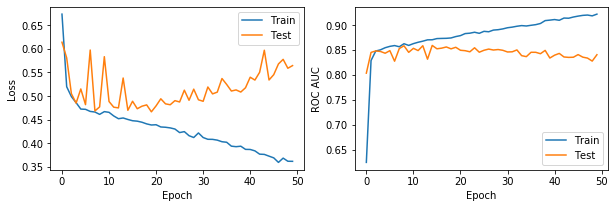

Neurons: 320;
 Layers: 5; 
 Function: elu; 
 Best result: 0.85921486331128

---



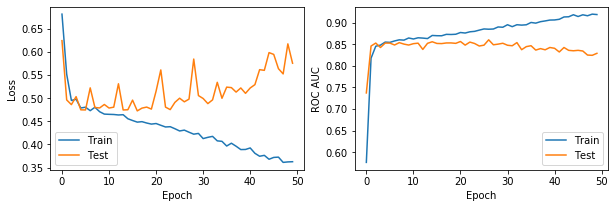

Neurons: 320;
 Layers: 10; 
 Function: elu; 
 Best result: 0.8607270412482533

---



In [141]:
#Меняем количество слоев

epochs = 50
f = F.elu
layers = [1, 2, 3, 5, 10]
neurons = 320
for l in layers:
  roc_auc = testNN(neurons, activation=f, num_epochs=epochs, num_layers=l);
  res.loc[len(res)] = [neurons, l, format_name(f), epochs, roc_auc, 3]
  print('\n---\n')

In [142]:
res.sort_values(by=['roc_auc_score'], ascending=False).loc[:, res.columns != 'index'].loc[res['index']== 3]

,neurons,layers,function,epochs,roc_auc_score
21,320,3,elu,50,0.864130
19,320,1,elu,50,0.861870
14,320,1,hardshrink,50,0.861618
23,320,10,elu,50,0.860727
15,320,2,hardshrink,50,0.859590
22,320,5,elu,50,0.859215
20,320,2,elu,50,0.858432
16,320,3,hardshrink,50,0.857098
17,320,5,hardshrink,50,0.855227
18,320,10,hardshrink,50,0.525287


In [ ]:
# Лучший результат 0.8641 
# получился при 320 нейронах, 3х слоях и с использованием Exponential Linear Unit функции

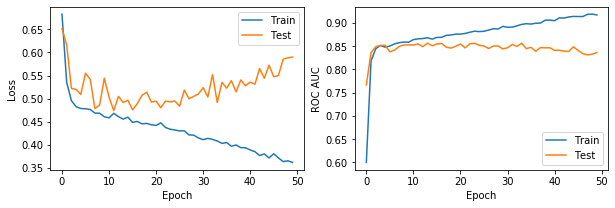

Neurons: 320;
 Layers: 3; 
 Function: elu; 
 Best result: 0.8565910612708305


In [17]:
# Исследуем влияние dropout на устойчивость работы нейронной сети на лучшем результате
# Собираем оптимальную модель вручную
ns = 320
epochs = 50
model = nn.Sequential( 
          nn.Linear(X_train.shape[1], ns), 
          nn.ELU(), 
          nn.Linear(ns, ns), 
          nn.ELU(), 
          nn.Linear(ns, ns), 
          nn.ELU(),
          nn.Linear(ns, ns), 
          nn.Dropout(p=0.2), 
          nn.ELU(),
          nn.Linear(ns, 1))
best_metric = train_model(model, train_dataloader, test_dataloader, torch.device("cpu"), num_epochs=epochs)
print(f"Neurons: 320;\n Layers: 3; \n Function: elu; \n Best result: {best_metric}")

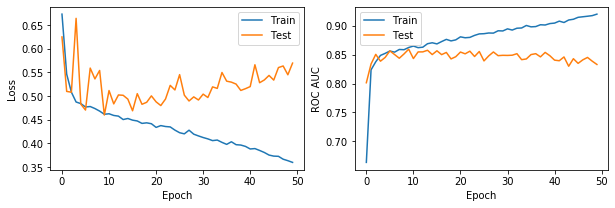

Neurons: 320;
 Layers: 3; 
 Function: elu; 
 Best result: 0.8596003830283726
Neurons: 320;
 Layers: 3; 
 Function: elu; 
 Best result: 0.8596003830283726


In [18]:
# Сравниваем с моделью без дропаута

epochs = 50
f = F.elu
layers = 3
neurons = 320
roc_auc = testNN(neurons, activation=f, num_epochs=epochs, num_layers=layers);
print(f"Neurons: 320;\n Layers: 3; \n Function: elu; \n Best result: {roc_auc}")

In [ ]:
# По графикам можно судить, что дропаут не влияет на устойчивость модели

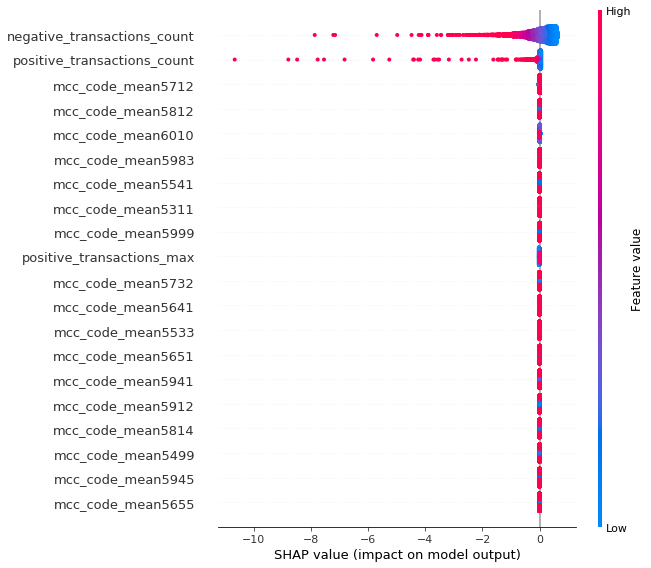

In [150]:
# Определяем наиболее информативные признаки

model = NN(X_train.shape[1], num_layers = 3, layer_size = 320, activation = F.elu)
tensor = torch.tensor(X_train.values, dtype = torch.float32)
e = shap.DeepExplainer(model, tensor) 
shap_values = e.shap_values(tensor)
shap.summary_plot(shap_values, features = X_train, feature_names = X_train.columns)

In [ ]:
# Заключение
# С помощью настроенной сети удалось добиться почти такого же результата
# как с бустингом (86,4 против 87,5)
# Поэтому для данной задачи одинакого хорошо подходят и нейросеть, и градиентный бустинг